# Práctico 2: Recomendación de videojuegos

En este práctico trabajaremos con un subconjunto de datos sobre [videojuegos de Steam](http://cseweb.ucsd.edu/~jmcauley/datasets.html#steam_data). Para facilitar un poco el práctico, se les dará el conjunto de datos previamente procesado. En este mismo notebook mostraremos el proceso de limpieza, para que quede registro del proceso (de todas maneras, por el tamaño de los datos no recomendamos que pierdan tiempo en el proceso salvo que lo consideren útil a fines personales). 

El conjunto de datos se basa en dos partes: lista de juegos (items), y lista de reviews de usuarios sobre distintos juegos. Este último, en su versión original es muy grande, (pesa 1.3GB), por lo que será solo una muestra del mismo sobre la que trabajarán.

A diferencia del conjunto de datos de LastFM utilizados en el [Práctico 1](./practico1.ipynb), en este caso los datos no están particularmente pensados para un sistema de recomendación, por lo que requerirá de un poco más de trabajo general sobre el dataset.

La idea es que, de manera similar al práctico anterior, realicen un sistema de recomendación. A diferencia del práctico anterior, este será un poco más completo y deberán hacer dos sistemas, uno que, dado un nombre de usuario le recomiende una lista de juegos, y otro que dado el título de un juego, recomiende una lista de juegos similares. Además, en este caso se requiere que el segundo sistema (el que recomienda juegos basado en el nombre de un juego en particular) haga uso de la información de contenido (i.e. o bien harán un filtrado basado en contenido o algo híbrido).

## Obtención y limpieza del conjunto de datos

El conjunto de datos originalmente se encuentra en archivos que deberían ser de formato "JSON". Sin embargo, en realidad es un archivo donde cada línea es un objeto de JSON. Hay un problema no obstante y es que las líneas están mal formateadas, dado que no respetan el estándar JSON de utilizar comillas dobles (**"**) y en su lugar utilizan comillas simples (**'**). Afortunadamente, se pueden evaluar como diccionarios de Python, lo cuál permite trabajarlos directamente.

### Descarga

La siguiente celda descarga los conjuntos de datos crudos. Nuevamente, no es necesario ejecutarla y pueden ir [más abajo](#Conjunto-de-datos-limpio) para ejecutar la celda que descargará el conjunto ya procesado.

In [ ]:
%%bash

mkdir -p data/steam/
curl -L -o data/steam/steam_games.json.gz http://cseweb.ucsd.edu/\~wckang/steam_games.json.gz
curl -L -o data/steam/steam_reviews.json.gz http://cseweb.ucsd.edu/\~wckang/steam_reviews.json.gz

### Carga de datos

Como se dijo, por la naturaleza de los datos, necesitamos utilizar Python para trabajarlos (no podemos leerlos con JSON).

In [30]:
import gzip
from tqdm import tqdm_notebook  # To print a progress bar (comes with Anaconda or can be installed)

with gzip.open("./data/steam/steam_games.json.gz") as fh:
    games = []
    for game in tqdm_notebook(fh, total=32135):
        try:
            games.append(eval(game))
        except SyntaxError:
            continue

print("Loaded {} games".format(len(games)))

with gzip.open("./data/steam/steam_reviews.json.gz") as fh:
    reviews = []
    for review in tqdm_notebook(fh, total=7793069):
        try:
            reviews.append(eval(review))
        except SyntaxError:
            continue

print("Loaded {} user reviews".format(len(reviews)))


Loaded 32135 games


FileNotFoundError: [Errno 2] No such file or directory: './data/steam/steam_reviews.json.gz'

### Exploración de los datos

En esta parte necesitamos revisar la estructura general, para poder pasarlos a un formato más amigable (e.g. CSV).

In [ ]:
games[0]

In [ ]:
reviews[0]

### Transformación de los datos

Viendo los datos que tenemos de cada tipo, podemos utilizar pandas para leer los registros y trabajar con algo más sencillo.

In [6]:
import pandas as pd

In [83]:
games = pd.DataFrame.from_records(games)
games.head(3)

,publisher,genres,app_name,title,release_date,tags,discount_price,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,[Single-player],4.99,False,7611,Kotoshiro,None,None
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,6439,Secret Level SRL,Mostly Positive,None
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,6702,Poolians.com,Mostly Positive,None


In [84]:
reviews = pd.DataFrame.from_records(reviews)
reviews.head(3)

,username,product_id,page_order,text,hours,products,date,early_access,page,compensation,found_funny,user_id
0,xXx_THOTDESTROYER_xXx,17510,3,It's a nice game.,23.8,67.0,2015-10-04,False,26,None,1.0,NaN
1,ProletusMAXIMUS,10180,2,900 hours of fun,100.2,154.0,2013-07-11,False,1077,None,NaN,7.656120e+16
2,museste,320840,8,One for the Amiga enthusiast!\nI owned the ori...,2.7,346.0,2015-04-02,False,10,None,NaN,7.656120e+16


### Selección de características

Teniendo los datos, podemos hacer una selección muy superficial (no basada en EDA) de algunas características que consideremos irrelevantes. En particular, para el caso del dataset de juegos, vemos que las columnas `url` y `reviews_url` no son útiles a los propósitos de este práctico, por lo que las removeremos.

Por el lado del dataset de opiniones todas parecen útiles. Aunque, si vemos muy por arriba `recommended` vemos que para todos los valores son `True`, por lo que la podemos sacar también.

In [86]:
games.drop(columns=["url", "reviews_url"], inplace=True)
games.head(3)

KeyError: "['url' 'reviews_url'] not found in axis"

In [8]:
reviews.drop(columns=["recommended"], inplace=True)
reviews.head(3)

NameError: name 'reviews' is not defined

### Muestreo y guarda de datos

Como dijimos, tenemos muchas reviews. Sería excelente trabajarlas a todas, pero el dataset es medio pesado (en RAM llega a ocupar más de 8 GB). Por lo que optaremos por hacer un muestreo de reviews. Esto quiere decir que, probablemente, algunos usuarios/juegos queden afuera. Podríamos hacer algún muestreo estratificado, pero iremos por algo más sencillo. Dejaremos aproximadamente el 10% del dataset (700 mil reviews).

El conjunto de datos de juegos lo dejaremos como está. Lo guardaremos con formato JSON para conservar la información de aquellas columnas que sean de tipo lista.

In [133]:
games.to_json("./data/steam/games.json.gz", orient="records")
reviews.sample(n=int(7e5), random_state=42).to_json("./data/steam/reviews.json.gz", orient="records")

FileNotFoundError: [Errno 2] No such file or directory: './data/steam/games.json.gz'

## Conjunto de datos limpio

Para descargar el conjunto de datos que se utilizará en el práctico, basta con ejecutar la siguiente celda.

In [ ]:
%%bash

mkdir -p data/steam/
curl -L -o data/steam/games.json.gz https://cs.famaf.unc.edu.ar/\~ccardellino/diplomatura/games.json.gz
curl -L -o data/steam/reviews.json.gz https://cs.famaf.unc.edu.ar/\~ccardellino/diplomatura/reviews.json.gz

## Ejercicio 1: Análisis Exploratorio de Datos

Ya teniendo los datos, podemos cargarlos y empezar con el práctico. Antes que nada vamos a hacer una exploración de los datos. Lo principal a tener en cuenta para este caso es que debemos identificar las variables con las que vamos a trabajar. A diferencia del práctico anterior, este conjunto de datos no está documentado, por lo que la exploración es necesaria para poder entender que cosas van a definir nuestro sistema de recomendación.

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

### Características del conjunto de datos sobre videojuegos

Las características del conjunto de datos de videojuegos tienen la información necesaria para hacer el "vector de contenido" utilizado en el segundo sistema de recomendación. Su tarea es hacer un análisis sobre dicho conjunto de datos y descartar aquella información redundante.

In [134]:
games = pd.read_json("./../data/steam/games.json.gz")
games.head()

,publisher,genres,app_name,title,release_date,tags,discount_price,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,[Single-player],4.99,False,7611,Kotoshiro,None,None
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,6439,Secret Level SRL,Mostly Positive,None
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,6702,Poolians.com,Mostly Positive,None
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,2017-12-07,"[Action, Adventure, Casual]",0.83,[Single-player],0.99,False,7674,彼岸领域,None,None
4,None,None,Log Challenge,None,None,"[Action, Indie, Casual, Sports]",1.79,"[Single-player, Full controller support, HTC V...",2.99,False,7735,None,None,None


In [91]:
# Completar
# Veamos los features que son redundantes, app_name y title tienen la misma info, por lo que eliminamos alguna
#idem con genres y tags, eliminamos tags
#idem con developer y publisher, eliminemos publisher
games.drop(columns=["app_name","tags","publisher"], inplace=True)
games.head()

,genres,title,release_date,discount_price,specs,price,early_access,id,developer,sentiment,metascore
0,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,2018-01-04,4.49,[Single-player],4.99,False,7611,Kotoshiro,None,None
1,"[Free to Play, Indie, RPG, Strategy]",Ironbound,2018-01-04,NaN,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,6439,Secret Level SRL,Mostly Positive,None
2,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,2017-07-24,NaN,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,6702,Poolians.com,Mostly Positive,None
3,"[Action, Adventure, Casual]",弹炸人2222,2017-12-07,0.83,[Single-player],0.99,False,7674,彼岸领域,None,None
4,None,None,None,1.79,"[Single-player, Full controller support, HTC V...",2.99,False,7735,None,None,None


In [52]:
games.count

<bound method DataFrame.count of               publisher                                             genres  \
0             Kotoshiro      [Action, Casual, Indie, Simulation, Strategy]   
1      Making Fun, Inc.               [Free to Play, Indie, RPG, Strategy]   
2          Poolians.com  [Casual, Free to Play, Indie, Simulation, Sports]   
3                  彼岸领域                        [Action, Adventure, Casual]   
4                  None                                               None   
...                 ...                                                ...   
32130   Ghost_RUS Games              [Casual, Indie, Simulation, Strategy]   
32131            Sacada                          [Casual, Indie, Strategy]   
32132      Laush Studio                        [Indie, Racing, Simulation]   
32133          SIXNAILS                                    [Casual, Indie]   
32134              None                                               None   

                       app_nam

### Características del conjunto de datos de reviews

Este será el conjunto de datos a utilizar para obtener información sobre los usuarios y su interacción con videojuegos. Como se puede observar no hay un rating explícito, sino uno implícito a calcular, que será parte de su trabajo (deberán descubrir que característica les puede dar información que puede ser equivalente a un rating).

In [3]:
reviews = pd.read_json("./../data/steam/reviews.json.gz")
reviews.head()

,username,product_id,page_order,text,hours,products,date,early_access,page,compensation,found_funny,user_id
0,xXx_THOTDESTROYER_xXx,17510,3,It's a nice game.,23.8,67.0,2015-10-04,False,26,None,1.0,NaN
1,ProletusMAXIMUS,10180,2,900 hours of fun,100.2,154.0,2013-07-11,False,1077,None,NaN,7.656120e+16
2,museste,320840,8,One for the Amiga enthusiast!\nI owned the ori...,2.7,346.0,2015-04-02,False,10,None,NaN,7.656120e+16
3,Totally Not Michael,6060,0,One of the best Starwars games i have ever pla...,8.5,101.0,2017-11-26,False,183,None,NaN,NaN
4,Undercooked Lasagna,433340,3,One of the best and most addicting games I've ...,19.3,28.0,2017-08-20,False,292,None,NaN,NaN


In [135]:
reviews[reviews['product_id']==6060]

,username,product_id,page_order,text,hours,products,date,early_access,page,compensation,found_funny,user_id
3,Totally Not Michael,6060,0,One of the best Starwars games i have ever pla...,8.5,101.0,2017-11-26,False,183,None,NaN,NaN
241,Canadianlemur,6060,5,░░░░░░░░░░░░▄▐\n░░░░░░▄▄▄░░▄██▄\n░░░░░▐▀█▀▌░░░...,53.7,82.0,2015-03-31,False,1606,None,1.0,NaN
306,jchild716,6060,2,good,10.4,81.0,2014-04-17,False,1958,None,NaN,7.656120e+16
698,MegasEvo,6060,8,"(Classic, 2005)",0.5,176.0,2017-11-30,False,126,None,2.0,NaN
1065,Stonewall5101,6060,4,"This is an amazing game in itself, and now wit...",11.6,32.0,2017-10-02,False,528,None,NaN,7.656120e+16
...,...,...,...,...,...,...,...,...,...,...,...,...
698419,[HmB] Great White,6060,5,Star Wars Battlefront II is hands down one of ...,16.3,48.0,2016-12-23,False,825,None,NaN,NaN
699254,ＧｒａｙＳｎｕｆｆ バ,6060,3,Stop reading reviews and buy it right now,4.6,69.0,2017-11-21,False,387,None,NaN,NaN
699278,Idunno55,6060,8,Normaly i would reccomend this but since games...,18.3,168.0,2016-01-23,False,1167,None,1.0,NaN
699864,Hello I,6060,9,Just. Buy. It.\nReason why : Story mode. Galac...,64.5,27.0,2016-01-08,False,1191,None,NaN,NaN


In [136]:
games[games['id']=='6060']

,publisher,genres,app_name,title,release_date,tags,discount_price,specs,price,early_access,id,developer,sentiment,metascore
9091,Lestyo,"[Casual, Indie]",Gump Runner,Gump Runner,2017-03-09,"[Indie, Casual]",NaN,"[Single-player, Steam Trading Cards]",0.99,False,6060,ArteG,4 user reviews,None
11694,Monster Couch,"[Action, Adventure, Indie, RPG]",Die for Valhalla!,Die for Valhalla!,TBA,"[Action, Adventure, Indie, RPG, 4 Player Local...",NaN,"[Single-player, Local Multi-Player, Local Co-o...",None,False,6060,Monster Couch,None,None
14771,Kalypso Media Digital,[Strategy],Sudden Strike 4 - Road to Dunkirk,Sudden Strike 4 - Road to Dunkirk,2017-10-20,[Strategy],NaN,"[Single-player, Multi-player, Online Multi-Pla...",9.99,False,6060,Kite Games,Mixed,None
18298,Iceflake Studios,[Racing],Race Arcade Original Soundtrack,Race Arcade Original Soundtrack,2017-04-05,[Racing],NaN,"[Downloadable Content, Full controller support]",3.99,False,6060,Iceflake Studios,None,None
18519,Orangepixel,[Action],Meganoid,Meganoid,2017-03-29,"[Action, Rogue-like, Pixel Graphics, Indie, Re...",NaN,"[Single-player, Steam Achievements, Full contr...",4.99,False,6060,Orangepixel,2 user reviews,None
18598,None,None,Weelco VR,None,None,"[Utilities, Video Production, Animation & Mode...",NaN,"[Full controller support, HTC Vive, Oculus Rif...",Free,False,6060,None,3 user reviews,None
18760,PrimeBit Games Sp. z o.o.,"[Action, Adventure, RPG]",Dark Tower,Dark Tower,2017-03-14,"[RPG, Adventure, Action]",NaN,[Single-player],2.99,False,6060,PrimeBit Games Sp. z o.o.,6 user reviews,None


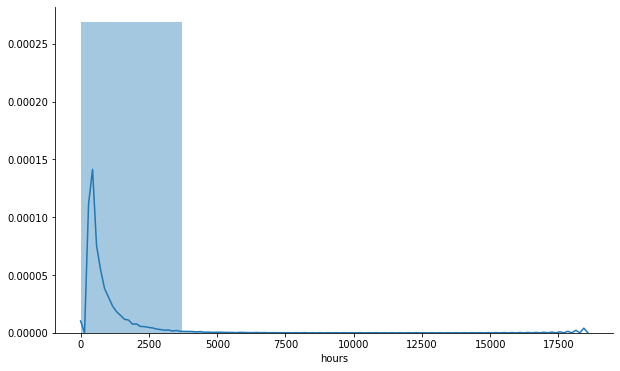

In [19]:
# Distribucion de los pesos con que se clasifican los juegos
plt.figure(figsize=(10,6))
seaborn.distplot(reviews['hours'].dropna(), bins=5)
seaborn.despine()

Creemos que es la columna hours indica si le gusto al usuario o no el juego.
Normalicemos las horas de juego

In [21]:
reviews['hours'].max()

18570.9

In [22]:
reviews['hours'].min()

0.0

## Ejercicio 2 - Sistema de Recomendación Basado en Usuarios

Este sistema de recomendación deberá entrenar un algoritmo y desarrollar una interfaz que, dado un usuario, le devuelva una lista con los juegos más recomendados.

In [ ]:
# Completar
#vemos que user_id no los tiene completos veamos como completarlos

In [18]:
reviews[['user_id','product_id','hours']].head()

,user_id,product_id,hours
0,NaN,17510,23.8
1,7.656120e+16,10180,100.2
2,7.656120e+16,320840,2.7
3,NaN,6060,8.5
4,NaN,433340,19.3


In [22]:
reviews['username'].unique()

array(['xXx_THOTDESTROYER_xXx', 'ProletusMAXIMUS', 'museste', ...,
       'zaffron', 'SeraphisCain', '[KOREA]Mary'], dtype=object)

In [ ]:
reviews['username'][:1000].head()

In [112]:
# Creamos username_id a partir del nombre con id nuevo, ya que los ids estan mal, pero
# como vimos arriba al ser tantos nos quedamos con los 4000 primeros
username_ids = {}
for idu, names in enumerate(reviews['username'].unique()[:1000]):
#for idu, names in enumerate(reviews['username'].unique()):
    username_ids[idu] = reviews['username'].unique()[idu]
print(len(username_ids))    

1000


In [39]:
username_ids

{0: 'xXx_THOTDESTROYER_xXx',
 1: 'ProletusMAXIMUS',
 2: 'museste',
 3: 'Totally Not Michael',
 4: 'Undercooked Lasagna',
 5: 'Prognome',
 6: 'FitzTalbot',
 7: 'Marcelo',
 8: 'Waitedboat4',
 9: 'Magic Max',
 10: 'bobnewrobot',
 11: 'Wiggles',
 12: 'Súper messi',
 13: 'K-ru',
 14: 'madpoet',
 15: 'LordInferno',
 16: 'J_ToSaveTheDay',
 17: 'FredBrooker',
 18: 'Pi55Pot',
 19: 'Micanful',
 20: 'smelly virgin',
 21: 'Lazystoner',
 22: 'Ace',
 23: 'Bill Nye Saves the world',
 24: 'Awake! Judgement Gun Morphing!',
 25: 'Fidelis',
 26: 'CryogenicFreeze',
 27: 'Comrades Before Capitalism',
 28: 'wiggs is the shiggs',
 29: 'Bouddi',
 30: "It's Just Aj Man",
 31: 'MacTombs',
 32: 'Thetigerisariver',
 33: 'Gropalopagus',
 34: 'Devilbronk666',
 35: 'Sole :)',
 36: 'Clone303',
 37: 'Matheuspontes14',
 38: 'melo',
 39: '╰<Revan The Dragon>╯',
 40: 'CraZY',
 41: 'Jiggly Josh',
 42: 'Sickhead',
 43: 'Terry',
 44: 'Spider',
 45: 'Zanes',
 46: 'Ready Player One ‡ð‡',
 47: 'マリズ',
 48: 'Lievly',
 49: 'Harem

In [49]:
username_ids.values()

dict_values(['xXx_THOTDESTROYER_xXx', 'ProletusMAXIMUS', 'museste', 'Totally Not Michael', 'Undercooked Lasagna', 'Prognome', 'FitzTalbot', 'Marcelo', 'Waitedboat4', 'Magic Max', 'bobnewrobot', 'Wiggles', 'Súper messi', 'K-ru', 'madpoet', 'LordInferno', 'J_ToSaveTheDay', 'FredBrooker', 'Pi55Pot', 'Micanful', 'smelly virgin', 'Lazystoner', 'Ace', 'Bill Nye Saves the world', 'Awake! Judgement Gun Morphing!', 'Fidelis', 'CryogenicFreeze', 'Comrades Before Capitalism', 'wiggs is the shiggs', 'Bouddi', "It's Just Aj Man", 'MacTombs', 'Thetigerisariver', 'Gropalopagus', 'Devilbronk666', 'Sole :)', 'Clone303', 'Matheuspontes14', 'melo', '╰<Revan The Dragon>╯', 'CraZY', 'Jiggly Josh', 'Sickhead', 'Terry', 'Spider', 'Zanes', 'Ready Player One ‡ð‡', 'マリズ', 'Lievly', 'Haremhaton', 'Timmy', 'S̴o̦l̺™͙̦̮̥̤̻̣͠', 'FiX`Leon', '[BSB] Rhym3z', 'Magical_Pony_Warrior', 'Grimm', 'Legend', '[GHPC] Callabaddie', 'SolarBear', 'SnackTimeCat', 'Lunaticon', 'iamthe3', 'CB', 'voltzila', 'McJesus', 'Loskoron', 'Dee

In [113]:
#hacemos un dic para arreglar el user_id
username_id_column = []
for i in reviews['username'][:1000]:
    #print(i)
    if i in username_ids.values():
        #print(i)
        #print(list(username_ids.keys())[list(username_ids.values()).index(i)])
        username_new = list(username_ids.keys())[list(username_ids.values()).index(i)]
        #print(username_new)
        username_id_column.append(username_new)
print(len(username_id_column))

1000


In [114]:
df_reviews = reviews[:1000].fillna(0)
df_reviews['user_id'] = username_id_column
df_reviews.to_csv("df_reviews.csv")

In [115]:
df_reviews[['user_id','product_id','hours']].head()

,user_id,product_id,hours
0,0,17510,23.8
1,1,10180,100.2
2,2,320840,2.7
3,3,6060,8.5
4,4,433340,19.3


In [116]:
from surprise import Dataset, Reader, KNNWithMeans, KNNBasic, NormalPredictor, KNNWithZScore
from surprise.model_selection import cross_validate, train_test_split
from surprise.accuracy import rmse

In [117]:
reader = Reader(rating_scale=(df_reviews.hours.min(), df_reviews.hours.max()))
videogames = Dataset.load_from_df(df_reviews[["user_id", "product_id", "hours"]], reader)

In [118]:
ratings_train, ratings_test = train_test_split(videogames, test_size=0.4)

In [119]:
model = KNNWithMeans(k=5).fit(ratings_train)
predictions = model.test(ratings_test)
print("RMSE on test: {:.4f}".format(rmse(predictions, verbose=False)))

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE on test: 228.0741


In [120]:
#cross validation
reviews_games = pd.read_csv("df_reviews.csv")

In [121]:
model = KNNWithMeans(k=5, verbose=False)
cross_validated_metrics = cross_validate(model, videogames, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    558.3541229.1077299.6834302.8487198.8716317.7731126.8293
MAE (testset)     140.9051119.6216135.1579125.1101109.3655126.032111.1732 
Fit time          0.03    0.02    0.03    0.02    0.02    0.02    0.01    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


In [137]:
from scipy.sparse import csr_matrix
import numpy

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        product_mapper: dict that maps user id's to product indices
        user_inv_mapper: dict that maps user indices to user id's
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
    """
    M = df['user_id'].nunique()
    N = df['product_id'].nunique()

    user_mapper = dict(zip(numpy.unique(df['user_id']), list(range(M))))
    product_mapper = dict(zip(numpy.unique(df["product_id"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), numpy.unique(df['user_id'])))
    product_inv_mapper = dict(zip(list(range(N)), numpy.unique(df["product_id"])))
    
    user_index = [user_mapper[i] for i in df['user_id']]
    item_index = [product_mapper[i] for i in df['product_id']]

    X = csr_matrix((df["hours"], (user_index, item_index)), shape=(M,N))
    
    return X, user_mapper, product_mapper, user_inv_mapper, product_inv_mapper

X, user_mapper, product_mapper, user_inv_mapper, product_inv_mapper = create_X(reviews_games)

In [123]:
reviews_games['product_id']

0       17510
1       10180
2      320840
3        6060
4      433340
        ...  
995    304050
996       500
997    334230
998    289650
999    261640
Name: product_id, Length: 1000, dtype: int64

In [138]:
def find_similar_games(games_id, X, games_mapper, games_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        artist_id: id of the artist of interest
        X: user-artist utility matrix
        k: number of similar artist to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar artist ID's
    """
    X = X.T
    games_ids = []
    
    games_ind = games_mapper[games_id]
    print(games_ind)
    games_vec = X[games_ind]
    print(games_vec)
    if isinstance(games_vec, (numpy.ndarray)):
        games_vec = games_vec.reshape(1,-1)
    
    # use k+1 since kNN output includes the artistID of interest
    kNN = NearestNeighbors(n_neighbors = k + 1, algorithm = 'brute', metric = metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(games_vec, return_distance = False)
    
    for i in range(0, k):
        n = neighbour.item(i)
        games_ids.append(games_inv_mapper[n])
        
    games_ids.pop(0)
    return games_ids

In [125]:
n_ratings_per_game = X.getnnz(axis=0)

print(f"Most rated game has {n_ratings_per_game.max()} ratings.")
print(f"Least rated game has {n_ratings_per_game.min()} ratings.")

Most rated game has 29 ratings.
Least rated game has 1 ratings.


## Ejercicio 3 - Sistema de Recomendación Basado en Juegos

Similar al caso anterior, con la diferencia de que este sistema espera como entrada el nombre de un juego y devuelve una lista de juegos similares. El sistema deberá estar programado en base a información de contenido de los juegos (i.e. filtrado basado en contenido o sistema híbrido).

In [139]:
games['title'].head

<bound method NDFrame.head of 0             Lost Summoner Kitty
1                       Ironbound
2         Real Pool 3D - Poolians
3                         弹炸人2222
4                            None
                   ...           
32130              Colony On Mars
32131    LOGistICAL: South Africa
32132               Russian Roads
32133         EXIT 2 - Directions
32134                        None
Name: title, Length: 32135, dtype: object>

In [140]:
games.head()

,publisher,genres,app_name,title,release_date,tags,discount_price,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,[Single-player],4.99,False,7611,Kotoshiro,None,None
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,6439,Secret Level SRL,Mostly Positive,None
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,6702,Poolians.com,Mostly Positive,None
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,2017-12-07,"[Action, Adventure, Casual]",0.83,[Single-player],0.99,False,7674,彼岸领域,None,None
4,None,None,Log Challenge,None,None,"[Action, Indie, Casual, Sports]",1.79,"[Single-player, Full controller support, HTC V...",2.99,False,7735,None,None,None


In [100]:
list(games.index)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [147]:
# hagamos entero en id del juego
integer_id = []
for i in games['id']:
    string = str(i)
    #print(string)
    #print(string[:-2])
    integer_id.append(string)
games['id'] = integer_id
games.head()

,publisher,genres,app_name,title,release_date,tags,discount_price,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,[Single-player],4.99,False,7611,Kotoshiro,None,None
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,6439,Secret Level SRL,Mostly Positive,None
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,6702,Poolians.com,Mostly Positive,None
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,2017-12-07,"[Action, Adventure, Casual]",0.83,[Single-player],0.99,False,7674,彼岸领域,None,None
4,None,None,Log Challenge,None,None,"[Action, Indie, Casual, Sports]",1.79,"[Single-player, Full controller support, HTC V...",2.99,False,7735,None,None,None


In [143]:
# this makes an dictionary with the key database for all unique games
gamename_dict = {}
gamename_dictTwo = {}
for idx, names in enumerate(games['title']):
    if games['id'][idx] not in gamename_dict:
        gamename_dict[games['id'][idx]] = games['title'][idx]
        gamename_dictTwo[games['title'][idx]] = games['id'][idx]
    else:
        continue
gamename_dict

{'7611': 'Lost Summoner Kitty',
 '6439': 'Ironbound',
 '6702': 'Real Pool 3D - Poolians',
 '7674': '弹炸人2222',
 '7735': None,
 '7725': 'Battle Royale Trainer',
 '7742': 'SNOW - All Access Basic Pass',
 '7688': 'Race',
 '7685': 'Uncanny Islands',
 '7249': None,
 '7703': 'Army of Tentacles: (Not) A Cthulhu Dating Sim: Black GOAT of the Woods Edition',
 '7653': 'Planetarium 2 - Zen Odyssey',
 '7736': 'The first thrust of God',
 '6402': None,
 '7680': 'The Warrior Of Treasures',
 '7114': None,
 '7758': 'RC Plane 3 - Canyon Scenario',
 '6539': 'DinoBlaster',
 '7779': 'Robotpencil Presents: Understanding 3D for Concept',
 '2820': 'Carmageddon Max Pack',
 '': 'Half-Life',
 '7523': 'Fallen Mage',
 '5942': None,
 '5206': 'Lost Cities',
 '6904': 'Twisted Enhanced Edition',
 '7668': 'Vaporwave Simulator',
 '4131': 'Tactics Forever',
 '7731': 'Christmas Santa Troubles',
 '6809': None,
 '7543': 'Underdone - Soundtrack',
 '7161': 'Bitcoin Clicker',
 '16': "Disciples II: Gallean's Return",
 '24': 'The

In [146]:
gamename_dict['6060']

'Gump Runner'

In [145]:
reviews_games['product_id'][3]

6060

In [75]:
reviews_games['product_id'][3] in gamename_dict['id'].values

False

In [110]:
reviews_games[reviews_games['product_id']==2907]

,Unnamed: 0,username,product_id,page_order,text,hours,products,date,early_access,page,compensation,found_funny,user_id


In [79]:
games[games['id']==6060]

,publisher,genres,app_name,title,release_date,tags,discount_price,specs,price,early_access,id,developer,sentiment,metascore


In [62]:
# this makes an dictionary with the key database for all unique games
#gamename_dict = {}
#gamename_dictTwo = {}
#for idx in enumerate(reviews_games['product_id']):
#    if games['id'][idx] not in gamename_dict:
#        gamename_dict[games['id'][idx]] = games['title'][idx]
#        gamename_dictTwo[games['title'][idx]] = games['id'][idx]
#    else:
#        continue
#gamename_dict

KeyError: (0, 17510)

In [33]:
product_mapper

{50: 0,
 220: 1,
 440: 2,
 620: 3,
 2310: 4,
 3020: 5,
 6060: 6,
 6880: 7,
 7670: 8,
 7940: 9,
 8850: 10,
 9930: 11,
 10110: 12,
 10180: 13,
 17470: 14,
 17510: 15,
 20500: 16,
 20920: 17,
 22330: 18,
 22370: 19,
 32370: 20,
 40800: 21,
 44350: 22,
 47780: 23,
 48700: 24,
 49520: 25,
 55230: 26,
 63380: 27,
 65800: 28,
 94000: 29,
 99900: 30,
 102700: 31,
 107100: 32,
 107410: 33,
 200150: 34,
 200510: 35,
 200710: 36,
 202750: 37,
 202970: 38,
 204360: 39,
 206190: 40,
 206440: 41,
 206480: 42,
 207140: 43,
 207930: 44,
 208090: 45,
 209650: 46,
 211820: 47,
 211970: 48,
 213670: 49,
 214340: 50,
 215530: 51,
 215630: 52,
 216150: 53,
 219190: 54,
 219830: 55,
 221100: 56,
 221640: 57,
 221910: 58,
 224260: 59,
 225540: 60,
 226740: 61,
 227300: 62,
 227940: 63,
 230410: 64,
 232090: 65,
 233450: 66,
 234080: 67,
 235600: 68,
 237930: 69,
 238210: 70,
 239350: 71,
 239660: 72,
 240720: 73,
 241930: 74,
 242640: 75,
 243970: 76,
 247080: 77,
 247870: 78,
 248610: 79,
 252490: 80,
 2532

In [55]:
reviews_games.head()

,Unnamed: 0,username,product_id,page_order,text,hours,products,date,early_access,page,compensation,found_funny,user_id
0,0,xXx_THOTDESTROYER_xXx,17510,3,It's a nice game.,23.8,67.0,2015-10-04,False,26,0,1.0,0
1,1,ProletusMAXIMUS,10180,2,900 hours of fun,100.2,154.0,2013-07-11,False,1077,0,0.0,1
2,2,museste,320840,8,One for the Amiga enthusiast!\nI owned the ori...,2.7,346.0,2015-04-02,False,10,0,0.0,2
3,3,Totally Not Michael,6060,0,One of the best Starwars games i have ever pla...,8.5,101.0,2017-11-26,False,183,0,0.0,3
4,4,Undercooked Lasagna,433340,3,One of the best and most addicting games I've ...,19.3,28.0,2017-08-20,False,292,0,0.0,4


In [59]:
product_mapper[50]

0

In [57]:
for i in reviews_games['product_id']:
    print(i)

17510
10180
320840
6060
433340
331200
204360
337320
506610
257400
50
435150
304050
476600
645790
22370
330830
215530
435140
388340
620
313120
48700
403640
612620
274290
335300
221910
211820
208090
291410
214340
284850
200510
397340
224260
20500
3020
240720
274940
260430
338170
353370
20920
332500
9930
444090
206440
423880
49520
206480
339800
200710
504370
282070
225540
216150
261030
266510
248610
401360
211820
247080
440
206190
370020
237930
289130
17470
49520
440
361420
234080
360430
263760
2310
7670
360430
598960
207140
391720
332800
232090
107100
10110
107410
219830
239660
284160
243970
317400
387860
444090
265550
63380
377160
233450
202750
291550
211970
22330
296770
22330
492400
440
213670
270170
323470
524220
312530
8850
327930
282140
260250
461680
6880
404410
241930
221640
282800
94000
107100
355180
253230
221640
433340
242640
312280
207930
304930
65800
257710
332800
200510
391540
406150
221100
224260
413410
433850
227940
261030
393380
620
252490
745880
440
460810
220
356520
3342

In [154]:
from sklearn.neighbors import NearestNeighbors
#def games_finder(title):
#    if title!=None: games[games['title'].str.contains(title)]['title'].tolist()
#    return None

#games_idx = dict(zip(games['title'], list(games.index)))
#games_idx
titleTwo = 'Gump Runner'
idx = gamename_dictTwo[titleTwo]
#idx = games_idx['Zen of Sudoku']
print(idx)
n_recommendations = 5

#idx = artist_idx[name]
print(product_mapper)
similar_games = find_similar_games(int(idx), X, product_mapper, product_inv_mapper, metric='cosine', k=10)

print(similar_games)
print('Recomendaciones para {} ({}):'.format(titleTwo, idx))
#print()
#for i in similar_games:
#    print('-', list(gamename_dictTwo.keys())[list(gamename_dictTwo.values()).index(i)], '(' + str(i) + ')')

6060
{50: 0, 70: 1, 220: 2, 240: 3, 300: 4, 400: 5, 440: 6, 500: 7, 620: 8, 730: 9, 1250: 10, 2100: 11, 2300: 12, 2310: 13, 2400: 14, 2820: 15, 3020: 16, 4000: 17, 4700: 18, 4760: 19, 6020: 20, 6060: 21, 6860: 22, 6880: 23, 7520: 24, 7600: 25, 7610: 26, 7670: 27, 7760: 28, 7940: 29, 8190: 30, 8400: 31, 8850: 32, 8930: 33, 9060: 34, 9480: 35, 9880: 36, 9930: 37, 10110: 38, 10180: 39, 10220: 40, 10500: 41, 12120: 42, 12220: 43, 13580: 44, 15390: 45, 17080: 46, 17390: 47, 17410: 48, 17470: 49, 17510: 50, 20500: 51, 20570: 52, 20920: 53, 21090: 54, 21100: 55, 21690: 56, 22120: 57, 22180: 58, 22320: 59, 22330: 60, 22370: 61, 23310: 62, 24010: 63, 24240: 64, 24960: 65, 24980: 66, 26800: 67, 32370: 68, 32470: 69, 32800: 70, 33230: 71, 33930: 72, 34830: 73, 34900: 74, 35450: 75, 35700: 76, 35720: 77, 39140: 78, 39150: 79, 39210: 80, 39540: 81, 39560: 82, 40800: 83, 42170: 84, 44350: 85, 45760: 86, 46480: 87, 47780: 88, 47890: 89, 48000: 90, 48190: 91, 48700: 92, 48720: 93, 49520: 94, 50130: 95

In [155]:
#def games_finder(title):
#    return games[games['title'].str.contains(title)]['title'].tolist()

#games_idx = dict(zip(games['title'], list(games.index)))
#title = games_finder('Ironbound')[0]
#n_recommendations = 5

#idx = games_idx[title]
#sim_scores = list(enumerate(cosine_sim[idx]))
#sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
#sim_scores = sim_scores[1:(n_recommendations+1)]
#similar_games = [i[0] for i in sim_scores]

#print("Recomendaciones para {}:".format(title))
#for game in games['title'].iloc[similar_games]:
#    print("\t{}".format(game))